# Recording Extracellular Potentials and Current Source Densities

Extracellular local field potential (LFP) recordings are among the most common electrophysiological recordings for studying brain function. Thus, many scientists might be interested in recording LFPs while simulating the activity of brain circuits to replicate or compare to in-vivo experimental recordings. This tutorial shows how to record extracellular LFPs with BioNet, modify the extracellular resistance, and calculate the current source density (CSD) generating the measured LFPs. 

---

## Contents
1. [Example: Recording Extracellular Local Field Potentials (LFPs)](#example-lfps)
2. [Example: Calculating the Current Source Density (CSD)](#example-cal-csd)


---

## Example: Recording Extracellular Local Field Potentials (LFPs) <a class="anchor" id="example-lfps">

A part of BioNet's built-in functionality is the ability to record extracellular LFPs from morphologically detailed networks of cells. Like with in-vivo experiments, it involves placing one or more electrodes by the cells that will pick up the change of the extracellular potentials throughout the experiment/simulation. This can be useful for comparing simulations to real experiment recordings taken from a M.E.A (multi-electrode array), neuronal probe, or even ECoG or EEG. It can also be used to calculate the current source density (CSD), thus capturing the slow-reacting, non-spiking dynamics of your network.

<br>
<div class="admonition note" name="html-admonition" style="background: lightgreen; padding: 10px">
Potential Restrictions
</div>
<br>

BMTK only supports capturing the LFPs for `biophysical` **model_type** cells. It will not work in PointNet since these are point-neuron cells (and many of the models are not conductance-based), so at the moment, BMTK does not have the ability to estimate segment membrane potential. Nor will it work with BioNet/NEURON `point-neuron` models. If a network contains a mix of both `biophysical` and `poinet-neuron` models, then the `point-neuron` models will be ignored when collecting extracellular recordings.

Also, **NOTE** that adding extracellular potential recordings to your network is computationally expensive. Expect simulations to take significantly longer than they would if you were just recording spikes or even membrane voltages.


### Step 1: Building a Network (Caveats)

Creating a network that is capable of recording LFPs is no different than the way you would normally create a SONATA-based network. And most of the time, we can dynamically add a recording electrode before any simulation. However, there are some requirements that we must be cognizant of:

1. Our network **MUST** have attributes **x**, **y**, **z** defined for all cells being recorded by our electrode (s). Variables like spiking events or membrane potential do not typically require explicit information about the cell position, so the exact coordinates of each cell are not required for them. But with extracellular recordings, the distances between the cells and electrodes will be very important in determining LFP.
2. You should also take care that **rotation_angle_xaxis**, **rotation_angle_yaxis**, and **rotation_angle_zaxis** are set properly. Especially if the cell is has extended morphology, it can make a big difference. However, if you want to use the default morphology from the *swc*, *asc*, *hoc*, etc, then not specifying the **rotation_angles** will just default rotations to 0.0

In this example, we build our network cells like such:
```python
x, y, z = get_coords(20, y_range=[-300, -100])
cortcol.add_nodes(
    N=20,

    # Reserved SONATA keywords used during simulation
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='Scnn1a_485510712_params.json',
    morphology='Scnn1a_485510712_morphology.swc',

    # The x, y, z locations and orientations (in Euler angles) of each cell
    # Here, rotation around the pia-to-white-matter axis is randomized
    x=x,
    y=y,
    z=z,
    rotation_angle_xaxis=0,
    rotation_angle_yaxis=np.random.uniform(0.0, 2 * np.pi, size=20),
    rotation_angle_zaxis=3.646878266,

    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
    layer='L23',
    model_name='Scnn1a',
    ei='e'
)
```

In this particular example, we use a very simplified "cortical column" consisting of layers `L2/3`, `L4` (which receives most of the external inputs), and `L5` pyramidal cells surrounded by inhibitory interneurons. The cells are built in a column parallel to the **y** axis and centered at **x=0** and **z=0**. 

We can use VND to visualize our network to make sure the layering and rotation of our cells are correct:

<br>
<div>
  <img src="../images/lfp_cortcol_small.png" width="500" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">

The full script for this example can be found in the file *build_network.lfp.py*. We encourage you to make changes and test out the effects that different cell types, synapses, and geometry have on LFP recordings. You can also try using a different network altogether.


### Step 2: Adding "ecp" recordings to simulation config.

The next step is to open up our SONATA simulation configuration file (*config.lfp.json*) so that it contains the following in the "reports" section.

```json
"reports": {
    "cortical_electrode": {
        "module": "extracellular",
        "variable_name": "v",
        "cells": "all",
        "electrode_positions": "./components/electrodes/linear_electrode.csv",
        "electrode_channels": "all"
    }
}
```
* The **module** should always be set to value `extracellular`, which tells BMTK what type of recording to apply.
* The **variable_name** should be set to `v`, which is the voltage just outside of every compartment's membrane.
* Setting **cells** to all tells BMTK to record the extracellular potential of all (biophysical) cells in the model. You can use the [node_set]() to select only a portion of cells to record from. For example, if you wanted to filter by specific node-ids:
```json
    "cells": {
        "population": "cortcol",
        "node_ids": [0, 100, 200, 300]
    },
```
&nbsp;&nbsp;&nbsp;&nbsp; or if you wanted to record from Layer 4 excitatory cells
```json
    "cells": {
        "layer": "L4",
        "ei": "e"
    },
```
* **electrode_positions** will point to the csv file containing recording electrodes (see below)
* We set **electrode_channels** to `all` to indicate the use of all possible electrodes in the electrodes csv file.



### Step 3: Creating electrodes file

We must tell BioNet the location of all recording electrodes, which we specify in the file *./componets/electrodes/linear_electrodes.csv*. This is a simple space-separated file where each line represents the `channel_id`, `x`, `y`, and `z` position for each channel that will be recording ecp from.

In [1]:
import pandas as pd


pd.read_csv('components/electrodes/linear_electrode.csv', sep=' ')

,channel,x_pos,y_pos,z_pos
0,0,0.0,0.0,0.0
1,1,0.0,-100.0,0.0
2,2,0.0,-200.0,0.0
3,3,0.0,-300.0,0.0
4,4,0.0,-400.0,0.0
5,5,0.0,-500.0,0.0
6,6,0.0,-600.0,0.0
7,7,0.0,-700.0,0.0
8,8,0.0,-800.0,0.0


In this example, an electrode array placed straight down the column will record the LFP at every 100-micron interval. Like with the placement of cells, we can use whatever coordinate framework for placing our network. In this case, we assume our columnar network's axis is aligned with the y-axis, which also passes through the center of the column. However, we could also use a global framework like the [CCF](https://biccn.org/standards/common-coordinate-frameworks-biccn). The important thing for BMTK is that the electrodes and cells must be in the same coordinate system. 

### Step 4: Running the simulation

Now that we've updated our simulation configuration accordingly, we can run the simulation like we normally would (be mindful that it will likely take longer and use more resources than normal):


In [2]:
! cd components/mechanisms && nrnivmodl modfiles

/home/kael/apps/miniconda3/envs/bmtk-workshop-2024/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/kael/Workspace/bmtk-workshop/opt_extracellular/components/mechanisms
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/exp1isyn.mod" "modfiles/modfiles/exp1syn.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/stp1syn.mod" "modfiles/modfiles/stp2syn.mod" "modfiles/modfiles/stp3syn.mod" "modfiles/modfiles/stp4syn.mod" "modfiles/modfiles/stp5isy

In [3]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.lfp.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-07-10 18:59:29,584 [INFO] Created log file
2024-07-10 18:59:29,706 [INFO] Building cells.
2024-07-10 18:59:39,186 [INFO] Building recurrent connections
2024-07-10 18:59:43,367 [INFO] Building virtual cell stimulations for virt_exc_spikes
2024-07-10 18:59:52,012 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-07-10 18:59:52,014 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-07-10 18:59:52,016 [INFO] Block save every 5000 steps
2024-07-10 19:03:32,698 [INFO]     step:5000 t_sim:500.00 ms
2024-07-10 19:07:34,348 [INFO]     step:10000 t_sim:1000.00 ms
2024-07-10 19:11:59,177 [INFO]     step:15000 t_sim:1500.00 ms
2024-07-10 19:16:56,470 [INFO]     step:20000 t_sim:2000.00 ms
2024-07-10 19:16:56,538 [INFO] Simulation completed in 17.0 minutes, 4.526 seconds 


### Step 5: Analyzing the results

The `bmtk.analyzer.ecp` package of BMTK includes a number of tools for analyzing and visualizing the results of the electrode recordings:


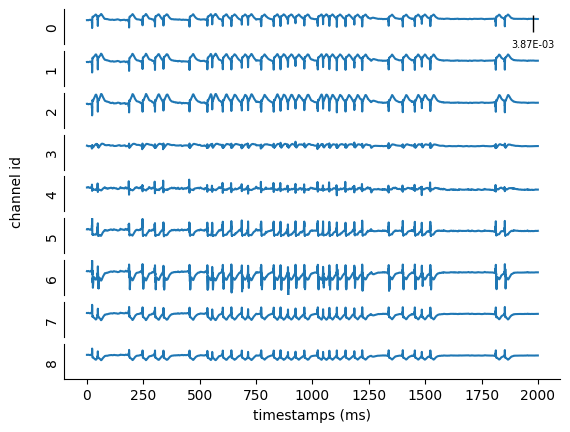

In [4]:
from bmtk.analyzer.ecp import plot_ecp

_ = plot_ecp(config_file='config.lfp.json', report_name='cortical_electrode')

But if you need to analyze the results yourself, they will be saved in the *output/cortical_electrode.h5* file, which is an HDF5 following SONATA format for [Extracellular reports](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#extracellular-report). The results are stored in the `/ecp/data` table that is $T \times N -(timestamps \times channels)$ in size.


<br>
<div>
  <img src="../images/hdf5_ecp_format.png" width="500" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">


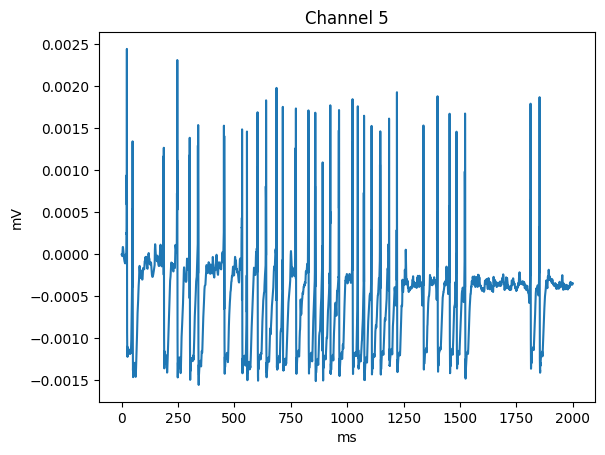

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

channel_id = 5

with h5py.File('output_lfp/cortical_electrode.h5', 'r') as h5:
    channel_idx = np.argwhere(h5['/ecp/channel_id'][()] == channel_id).flatten()
    ts = np.arange(start=h5['/ecp/time'][0], stop=h5['/ecp/time'][1], step=h5['/ecp/time'][2])
    plt.plot(ts, h5['/ecp/data'][:, channel_idx])
    plt.title(f'Channel {channel_id}')
    plt.xlabel(h5['/ecp/time'].attrs['units'])
    plt.ylabel(h5['/ecp/data'].attrs['units'])

### (Optional) Finding individual contributions

When each channel in the electrode calculates the ECP at each given time, it does so by taking the extracellular Vm of each cell, adjusting for distance and interstitial resistance, and summing the results over all recorded cells. 

Sometimes, for deeper analysis of a simulation, you may want to measure the individual contribution each cell has on the electrode. To do so in our simulation we just need to add the **contributions_dir** option to the simulation configuration:

```json
"reports": {
    "cortical_electrode": {
        "module": "extracellular",
        "variable_name": "v",
        "cells": "all",
        "electrode_positions": "./components/electrodes/linear_electrode.csv",
        "electrode_channels": "all",
        "contributions_dir": "cell_contributions"
    }
}
```

Now, when you run the simulation, it will add an extra directory *output_lfp/cell_contributions/* that will contain N SONATA Extracellular reports for each of the N individual cells (the name of each h5 file will correspond to the node_id of each cell).

Be **WARNED** that adding the "contributions_dir" option will take up a lot of disk space for even moderately sized networks. Feel free to edit *config.lfp.json* and see how different cells and cell-types differ in their LFP signatures.


## Example: Calculating the Current Source Density (CSD) <a class="anchor" id="example-cal-csd">

Scientists are often interested in estimating the current sources or CSD generating the measured LFPs. Calculating the CSD associated with simulated LFPs can also be useful for comparing simulations to experimental data. This example demonstrates how to compute the CSD from the simulated LFPs in the first example using the iCSD method from [Pettersen et al. 2006](https://doi.org/10.1016/j.jneumeth.2005.12.005). The iCSD methods can be applied to data recorded from multielectrode arrays with various geometries.

iCSD methods are available in the py-iCSD toolbox, which is a translation of the core functionality of the CSDplotter MATLAB package to Python. The py-ICSD toolbox can be downloaded from https://github.com/espenhgn/iCSD

In [6]:
import sys
sys.path.append('icsd_scripts/')

For the below scripts you will also need to install third party packages [quantities](https://github.com/python-quantities/python-quantities) and [neo](https://github.com/NeuralEnsemble/python-neo) to handle dimensional units and electrophysiology calculations, respectively

In [7]:
! pip install quantities
! pip install neo

In [8]:
import icsd
import quantities as pq

### Step 1: Setting up quantities for py-iCSD toolbox

All inputs to the iCSD methods class instances are considered Quantity arrays. First, we need to patch quantities with the SI unit Siemens if it does not exist:

In [9]:
for symbol, prefix, definition, u_symbol in zip(
    ['siemens', 'S', 'mS', 'uS', 'nS', 'pS'],
    ['', '', 'milli', 'micro', 'nano', 'pico'],
    [pq.A/pq.V, pq.A/pq.V, 'S', 'mS', 'uS', 'nS'],
    [None, None, None, None, u'µS', None]):
    if type(definition) is str:
        definition = lastdefinition / 1000
    if not hasattr(pq, symbol):
        setattr(pq, symbol, pq.UnitQuantity(
            prefix + 'siemens',
            definition,
            symbol=symbol,
            u_symbol=u_symbol))
    lastdefinition = definition

### Step 2: Preparing LFP data and defining parameters for the CSD calculation

The iCSD method considers the CSD to have cylindrical symmetry with a diameter `diam` specified by the user based on the geometry of your simulated network or the area captured by your experimental recordings. Here, we calculate the CSD assuming a homogenous conductivity `sigma` throughout the column and an infinite medium (i.e., the extracellular conductivity above the cortical surface is the same as the grey matter conductivity - `sigma_top = sigma`). However, you can use a different value for `sigma_top` if you use substances such as saline (with a high conductivity) or oil (with a very low conductivity) to prevent the brain from drying during your experiments.

In addition to these parameters, you need to input the LFP data `lfp` with units in SI, the coordinates of the electrodes `coord_electrode`, and the type `f_type` and order `f_order` of the spatial filter to be applied to the estimated CSD. You must append the corresponding quantities to `lfp`, `coord_electrode`, `diam`, `sigma`, and `sigma_top` to convert them to Quantity arrays.

Here, we will use the delta-iCSD method for calculating the CSD, using a Gaussian 3-point filter with a standard deviation equal to 1 (`sigma = 1`). However, the py-iCSD toolbox also includes the step-iCSD, spline-iCSD, and std or standard CSD methods. More details on these methods can be found in [Pettersen et al. 2006](https://doi.org/10.1016/j.jneumeth.2005.12.005). 

These are examples of the input dictionaries for each method:
```python
delta_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'diam' : diam,          # source diameter
    'sigma' : sigma,        # extracellular conductivity
    'sigma_top' : sigma,    # conductivity on top of cortex
    'f_type' : 'gaussian',  # gaussian filter
    'f_order' : (3, 1),     # 3-point filter, sigma = 1.
}
step_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'diam' : diam,
    'h' : h,                # source thickness
    'sigma' : sigma,
    'sigma_top' : sigma,
    'tol' : 1E-12,          # Tolerance in numerical integration
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
spline_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'diam' : diam,
    'sigma' : sigma,
    'sigma_top' : sigma,
    'num_steps' : 201,      # Spatial CSD upsampling to N steps
    'tol' : 1E-12,
    'f_type' : 'gaussian',
    'f_order' : (20, 5),
}
std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
```

Getting the simulated LFPs and electrodes' coordinates from the first example:

In [10]:
import h5py

with h5py.File('output_lfp/cortical_electrode.h5', 'r') as h5:
    channel_idx = h5['/ecp/channel_id'][()]
    ts = np.arange(start=h5['/ecp/time'][0], stop=h5['/ecp/time'][1], step=h5['/ecp/time'][2])
    lfp = h5['/ecp/data'][()]


coord_ele = pd.read_csv('components/electrodes/linear_electrode.csv', sep=' ')

Defining the input dictionary for the delta-iCSD method: 

In [11]:
z_data = np.array(coord_ele['y_pos']) * (-1E-6) * pq.m      # [um] --> [m] linear probe - electrodes' position in depth
diam = 800E-6 * pq.m                              # [m] source diameter
h = 100E-6 * pq.m                                 # [m] distance between channels
sigma = 0.3* pq.S / pq.m                          # [S/m] or [1/(ohm*m)] extracellular conductivity
sigma_top = 0.3* pq.S / pq.m                      # [S/m] or [1/(ohm*m)] conductivity on top of cortex

delta_input = {
        'lfp' : lfp.T*1E-3*pq.V, #[um] --> [V]
        'coord_electrode' : z_data,
        'diam' : diam,
        'sigma' : sigma,
        'sigma_top' : sigma_top,
        'f_type' : 'gaussian',  # gaussian filter
        'f_order' : (3, 1),     # 3-point filter, sigma = 1.
    }

### Step 3: Calculating the CSD

First, we create the delta CSD-method class instance:
```python
csd_dict = dict(
    delta_icsd = icsd.DeltaiCSD(**delta_input),
)
```

The class methods get_csd() and filter_csd() are used below to get the raw and spatially filtered versions of the CSD estimates. The raw- and filtered CSD estimates are returned as Quantity arrays. 

In the comments below, we illustrate how to calculate the CSD using the other methods, considering their input dictionary is defined as shown in Step 2.


In [12]:
csd_dict = dict(
    delta_icsd = icsd.DeltaiCSD(**delta_input),

    #Other methods for computing CSD:
    #step_icsd = icsd.StepiCSD(**step_input),
    #spline_icsd = icsd.SplineiCSD(**spline_input),
    #std_csd = icsd.StandardCSD(**std_input),
)

for method, csd_obj in list(csd_dict.items()):
    csd_raw =  csd_obj.get_csd()  # num_channels x trial_duration
    csd_smooth = csd_obj.filter_csd(csd_raw)  # num_channels x trial_duration

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


Text(0.5, 0, 'timestep')

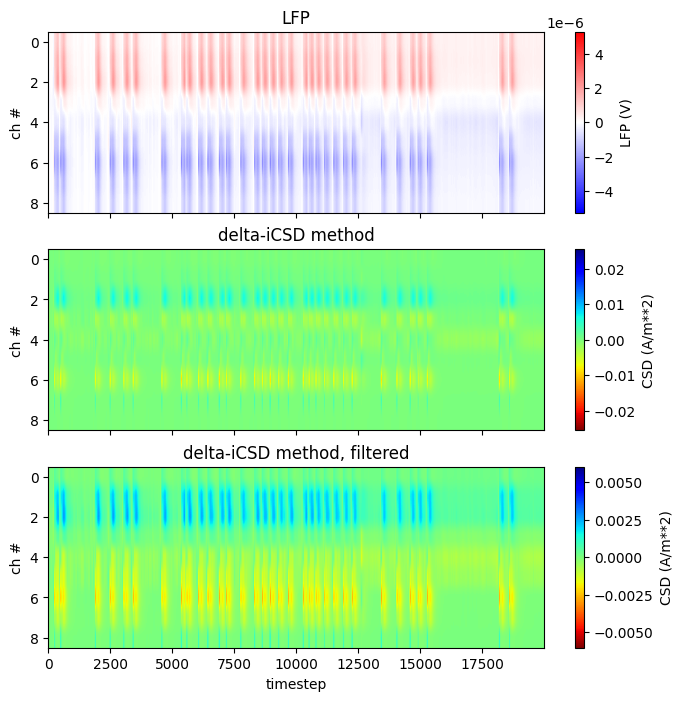

In [13]:
fig, axes = plt.subplots(3,1, figsize=(8,8))

lfp_data = lfp.T*1E-3*pq.V

#plot LFP signal
ax = axes[0]
im = ax.imshow(np.array(lfp_data), origin='upper', vmin=-abs(lfp_data).max(), \
          vmax=abs(lfp_data).max(), cmap='bwr')
ax.axis(ax.axis('tight'))
cb = plt.colorbar(im, ax=ax)
cb.set_label('LFP (%s)' % lfp_data.dimensionality.string)
ax.set_xticklabels([])
ax.set_title('LFP')
ax.set_ylabel('ch #')

#plot raw csd estimate
ax = axes[1]
im = ax.imshow(np.array(csd_raw), origin='upper', vmin=-abs(csd_raw).max(), \
      vmax=abs(csd_raw).max(), cmap='jet_r')
ax.axis(ax.axis('tight'))
ax.set_title(csd_obj.name)
cb = plt.colorbar(im, ax=ax)
cb.set_label('CSD (%s)' % csd_raw.dimensionality.string)
ax.set_xticklabels([])
ax.set_ylabel('ch #')

#plot spatially filtered csd estimate
ax = axes[2]
im = ax.imshow(np.array(csd_smooth), origin='upper', vmin=-abs(csd_smooth).max(), \
      vmax=abs(csd_smooth).max(), cmap='jet_r')
ax.axis(ax.axis('tight'))
ax.set_title(csd_obj.name + ', filtered')
cb = plt.colorbar(im, ax=ax)
cb.set_label('CSD (%s)' % csd_smooth.dimensionality.string)
ax.set_ylabel('ch #')
ax.set_xlabel('timestep')